To run a cell, type `Shift` + `Return`. Run the cell below to get started

In [1]:
from workshop_utils import * 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import datetime
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Buildings Example

_Tacloban, Philippines_

These next cells will load the output from the following query in Athena:

```sql
SELECT date_trunc('hour', updated), avg( date_diff('minute', updated, valid_until) ) AS avg_lifespan_minutes, count(distinct(changesets.uid)) AS num_users, count(*) AS new_buildings
FROM southeastern_asia
JOIN changesets on southeastern_asia.changeset = changesets.id
WHERE ST_WITHIN( geom , ST_Polygon('POLYGON((124.909271 11.293189, 125.088518 11.293189, 125.088518 10.954934, 124.909271 10.954934, 124.909271 11.293189))') )
        AND element_at(southeastern_asia.tags, 'building') IS NOT NULL
        AND version = 1
        AND minor_version < 1
GROUP BY  date_trunc('hour', updated)
```

In [2]:
#Tacloban, Philippines
#by hour?
tacloban = load_dataframe_from_s3('https://us-east-2.console.aws.amazon.com/athena/query/results/ad3e6852-95e0-4167-846d-b6910b7382ea/csv')
#by day
# tacloban = load_dataframe_from_s3('https://us-east-2.console.aws.amazon.com/athena/query/results/55f69638-8cd5-4e98-8370-7c87f56778a8/csv')


data/ad3e6852-95e0-4167-846d-b6910b7382ea.csv
Creating dataframe... done.  Found 764 rows

In [3]:
tacloban.head(2)

,_col0,avg_lifespan_minutes,num_users,new_buildings
0,2013-11-09 16:00:00.000,26953.972973,6,427
1,2013-11-08 22:00:00.000,91196.304348,5,349


In [4]:
#Rename the columns so they make more sense
tacloban.columns = ["datetime", "lifespan_minutes", "num_users", "objects"]

#Cast the date as date
tacloban['datetime'] = tacloban.datetime.apply(pd.Timestamp)

#Reindex (and sort)by date becuase the original query was organized that way
tacloban.set_index('datetime', inplace=True)
tacloban.sort_index(inplace=True)

#Add two new columns:
tacloban['lifespan_days'] = tacloban.lifespan_minutes.apply(lambda x: x/(60*24))
tacloban['object_percent'] = tacloban.objects / tacloban.objects.sum()

#Finally, show the new dataframe
tacloban.head(4)

,lifespan_minutes,num_users,objects,lifespan_days,object_percent
datetime,,,,,
2011-01-25 10:00:00,3062723.00,1,1,2126.890972,0.000014
2011-02-15 16:00:00,12732.00,1,1,8.841667,0.000014
2011-02-19 12:00:00,598909.75,1,4,415.909549,0.000056
2011-02-19 13:00:00,36581.00,1,1,25.403472,0.000014


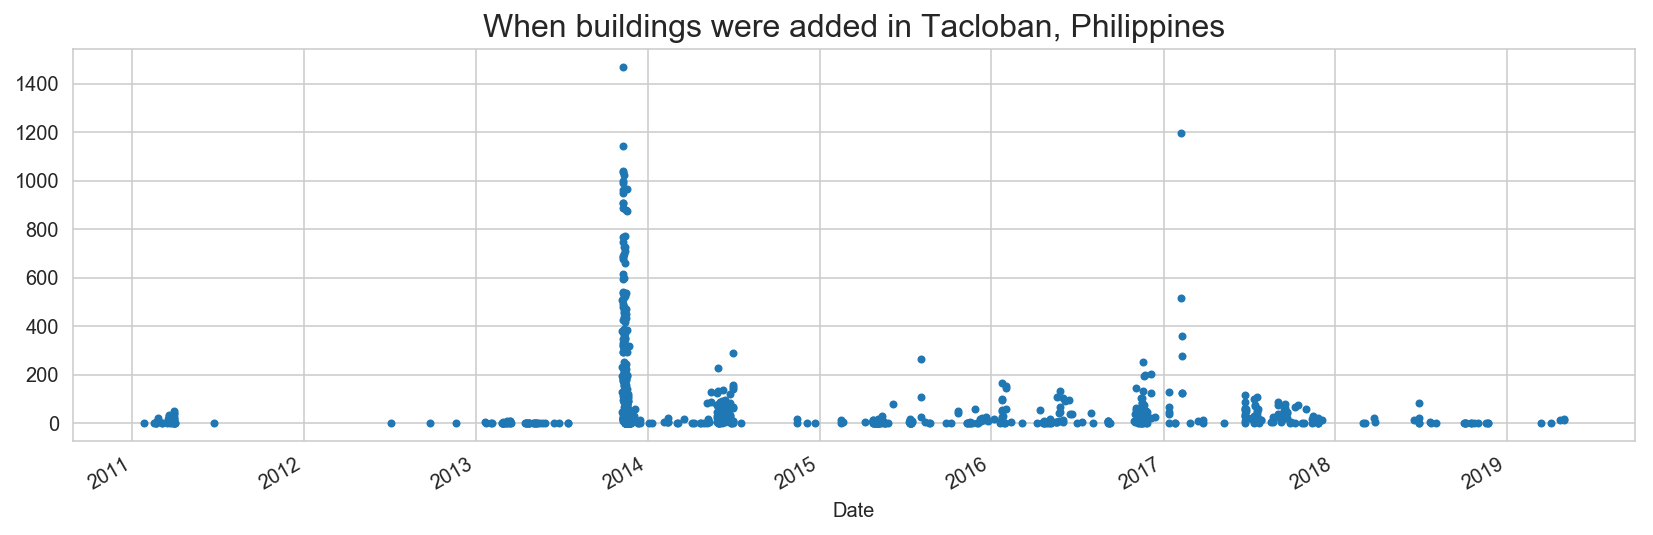

In [5]:
sns.set_style('whitegrid')
ax = tacloban['objects'].plot(style='.', figsize=(14,4))
# tacloban['objects'].plot(ax=ax)
ax.set_xlabel("Date"); ax.set_ylabel("");
ax.set_title("When buildings were added in Tacloban, Philippines",fontsize=16);

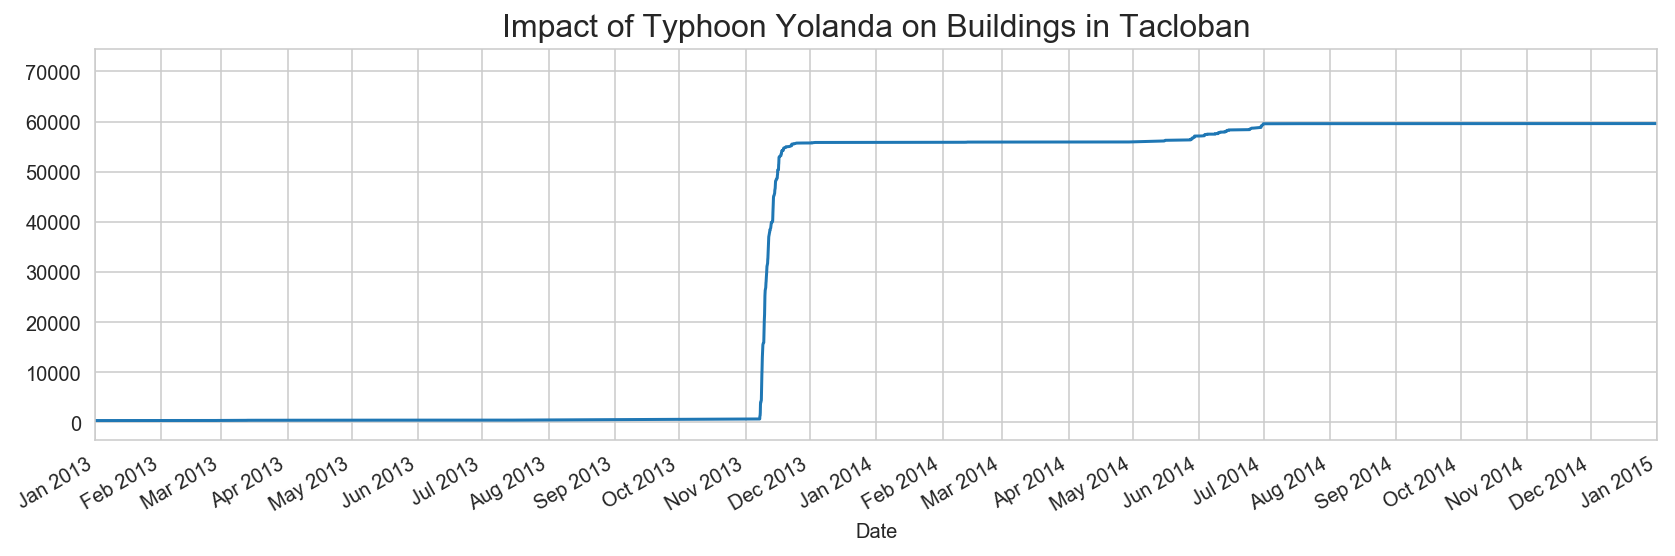

In [6]:
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(15,7))
tacloban['objects'].cumsum().plot(figsize=(14,4), ax=ax)
ax.set_xlabel("Date"); ax.set_ylabel("");
ax.set_title("Impact of Typhoon Yolanda on Buildings in Tacloban",fontsize=16);
ax.set_xlim([datetime.date(2013,1,1), datetime.date(2015,1,1)])
#set ticks every day
ax.xaxis.set_major_locator(mdates.MonthLocator())
#set major ticks format
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

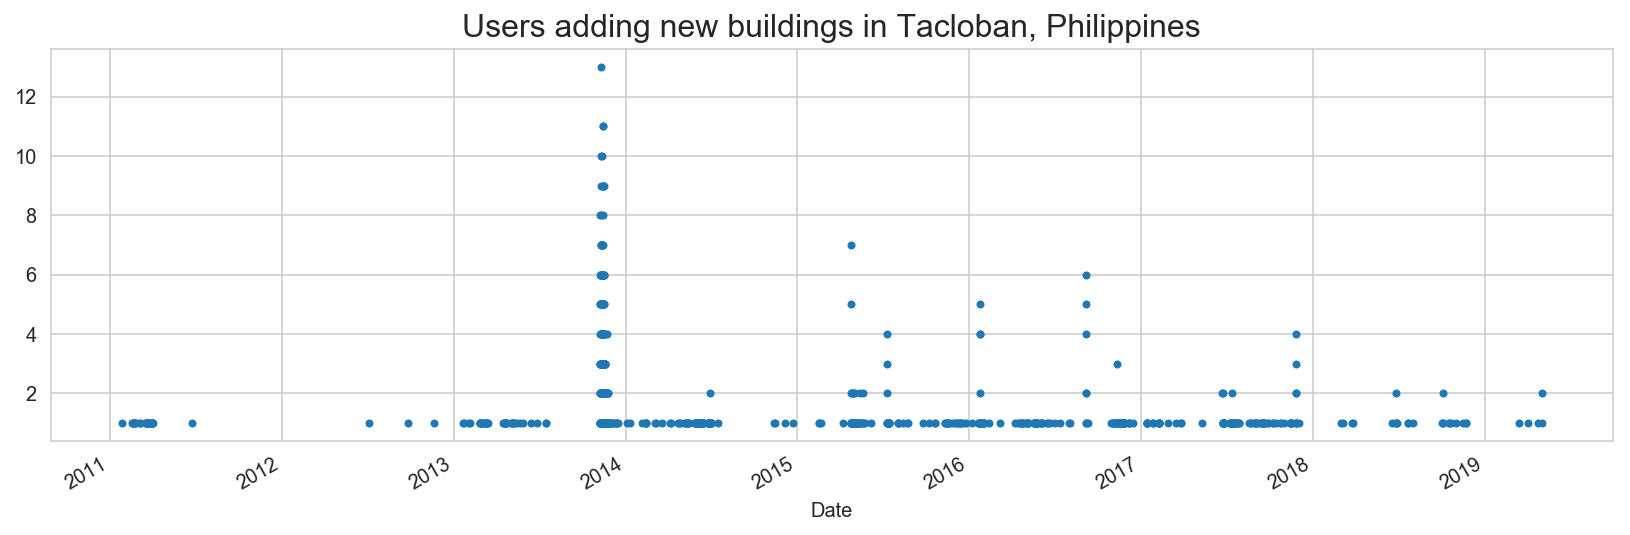

In [7]:
# These buildings were the work of how many users?
ax = tacloban['num_users'].plot(style=".", figsize=(14,4))
ax.set_xlabel("Date"); ax.set_ylabel(""); 
ax.set_title("Users adding new buildings in Tacloban, Philippines",fontsize=16);
# ax.set_xlim([datetime.date(2013,11,1), datetime.date(2013,11,30)]);


In [8]:
print("The number of buildings in Tacloban is: {:,}".format(tacloban.objects.sum()))

The number of buildings in Tacloban is: 71,018


## Now retrieve all of the actual buildings from Athena 


```sql
SELECT southeastern_asia.id AS id,
         southeastern_asia.type AS type,
         southeastern_asia.geom AS geom,
         southeastern_asia.tags AS b_tags,
         southeastern_asia.changeset,
         southeastern_asia.updated,
         southeastern_asia.valid_until,
         southeastern_asia.version,
         southeastern_asia.minor_version,
         changesets.id,
         changesets.uid,
         changesets.user,
         changesets.tags AS c_tags
FROM southeastern_asia
JOIN changesets
    ON southeastern_asia.changeset = changesets.id
WHERE ST_WITHIN( geom , ST_Polygon('POLYGON((124.909271 11.293189, 125.088518 11.293189, 125.088518 10.954934, 124.909271 10.954934, 124.909271 11.293189))') )
        AND element_at(southeastern_asia.tags, 'building') IS NOT NULL
```

In [9]:
buildings = load_dataframe_from_s3('https://us-east-2.console.aws.amazon.com/athena/query/results/8a2c934f-a883-4057-9e91-f9b7ce478c1d/csv')


data/8a2c934f-a883-4057-9e91-f9b7ce478c1d.csv
Creating dataframe... done.  Found 131,074 rows

In [10]:
buildings.head(2)

,id,type,geom,b_tags,changeset,updated,valid_until,version,minor_version,id.1,uid,user,c_tags
0,246084378,2,"POLYGON ((124.9931645 11.1915913, 124.993183 1...",{building=yes},18886625,2013-11-14 01:29:31.000,2013-11-14 06:55:24.000,1,0,18886625,893327,mcheckimport,{comment=job 338 validation areas http://tasks...
1,246146876,2,"POLYGON ((124.9358414 11.127572, 124.9358788 1...","{typhoon:damage=yes, source=WorldView-2,Digita...",18959159,2013-11-17 21:07:43.000,NaN,3,0,18959159,191979,It's so funny,{comment=Tacloban region - hamlet - new buildi...


In [11]:
# Cast timestamp to a date
buildings['date'] = buildings.updated.apply(lambda x: pd.Timestamp(x).date())

# How about the edit lifespan (time between edits)
buildings['lifespan'] = buildings.apply(lambda row: pd.Timestamp(row.valid_until) - pd.Timestamp(row.updated), axis=1)

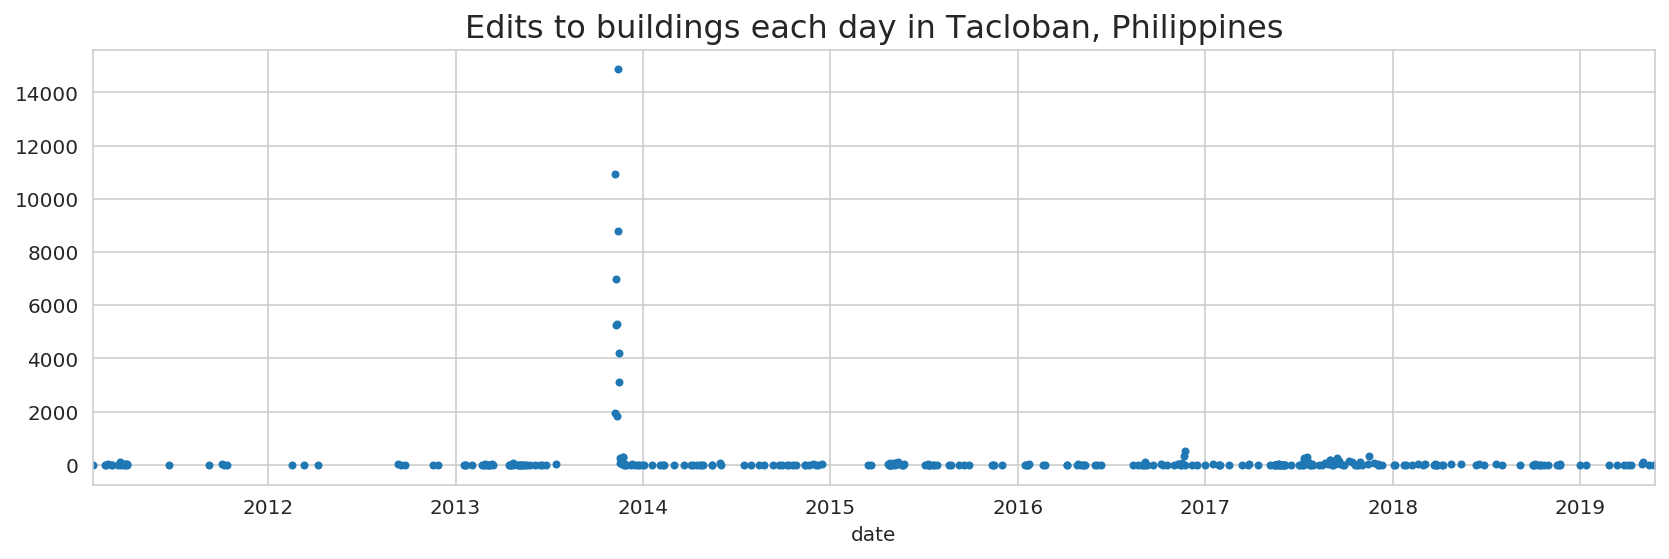

In [209]:
ax = buildings.groupby('date').aggregate('count')['id'].plot(style=".", figsize=(14,4))
ax.set_title("Edits to buildings each day in Tacloban, Philippines",fontsize=16);

### `Minor Version`

We can use the `minor version` attribute to identify geometry updates to buildings. This can be a form of validation behavior. identifying spikes in the occurence of these can identify map validation.

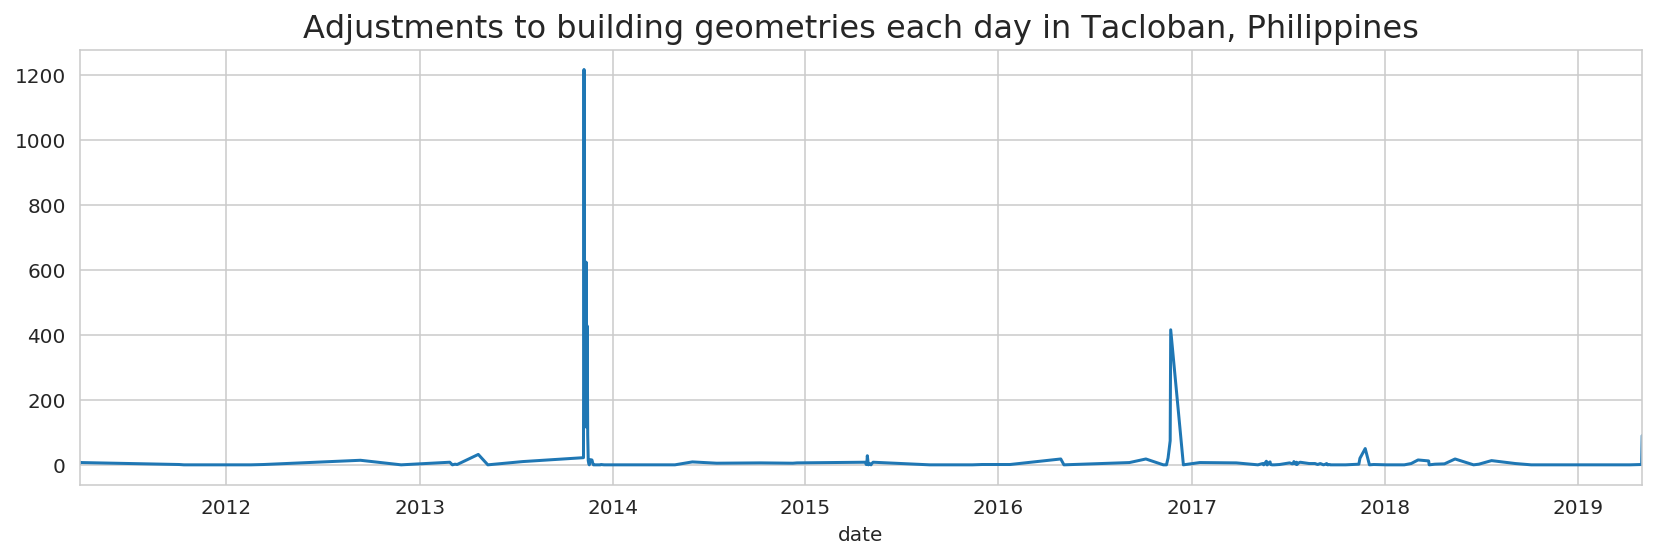

In [212]:
ax = buildings[buildings.minor_version>0].groupby('date').aggregate('count')['id'].plot(figsize=(14,4))
ax.set_title("Adjustments to building geometries each day in Tacloban, Philippines",fontsize=16);

What is the most edited building? 

In [219]:
# This is a bit hacky, but it definitely works
most_edited_building = pd.DataFrame(buildings[buildings.id==buildings.sort_values(
    by='version',ascending=False).id.values[0]].sort_values(
      by=['version','minor_version'],ascending=False))

print("most edited building: http://openstreetmap.org/way/{}\nThe most recent three edits:".format(most_edited_building.id.values[0]))

most_edited_building.head(3)

most edited building: http://openstreetmap.org/way/119984693
The most recent three edits:


,id,type,geom,b_tags,changeset,updated,valid_until,version,minor_version,id.1,uid,user,c_tags,date,lifespan
33093,119984693,2,"POLYGON ((125.0082895 11.2071619, 125.0084121 ...","{shop=mall, name=Robinsons Place Tacloban, bui...",52197528,2017-09-20 03:58:58.000,NaN,17,1,52197528,1645185,RoyalKnight,"{host=https://www.openstreetmap.org/edit, imag...",2017-09-20,NaT
70093,119984693,2,"POLYGON ((125.0082895 11.2071559, 125.0084121 ...","{shop=mall, name=Robinsons Place Tacloban, bui...",45206815,2017-01-16 05:14:50.000,2017-09-20 03:58:58.000,17,0,45206815,1645185,RoyalKnight,"{host=https://www.openstreetmap.org/id, imager...",2017-01-16,246 days 22:44:08
46745,119984693,2,"POLYGON ((125.0082895 11.2071559, 125.0084121 ...","{shop=mall, name=Robinsons Place Tacloban, bui...",45206762,2017-01-16 05:10:18.000,2017-01-16 05:14:50.000,16,0,45206762,1645185,RoyalKnight,"{host=https://www.openstreetmap.org/id, imager...",2017-01-16,0 days 00:04:32


In [220]:
# Extending that, which buildings were edited by the most people?

buildings.groupby('id').aggregate({
    'uid':pd.Series.nunique,
    'version':pd.Series.max,
    'lifespan': pd.Series.mean
}).sort_values(by='uid',ascending=False).head()

,uid,version,lifespan
id,,,
119984693,11,17,115 days 23:45:37.473684
208504285,9,8,276 days 11:47:34.625000
105270169,9,7,305 days 23:21:44.111111
104946269,9,7,305 days 05:53:05.875000
245223918,9,9,99 days 18:37:37.750000


# For comparison, look at Pokhara, Nepal:

```sql
SELECT date_trunc('day', updated), avg( date_diff('minute', updated, valid_until) ) AS lifespan_minutes, count(distinct(changeset)) AS changesets, count(*) AS objects
FROM nepal
WHERE ST_WITHIN( geom , ST_Polygon('POLYGON((83.783947 28.38623, 84.182564 28.38623, 84.182564 28.055363, 83.783947 28.055363, 83.783947 28.38623))') )
        AND element_at(nepal.tags, 'building') IS NOT NULL
        AND version = 1
        AND minor_version < 1
GROUP BY  date_trunc('day', updated)
```

In [221]:
# Using another existing query: 
df = load_dataframe_from_s3("https://us-east-2.console.aws.amazon.com/athena/query/results/4f97aee9-8d98-40c8-a711-e5b2fef0c318/csv")


Found file locally... Creating dataframe... done.  Found 747 rows

In [222]:
#What does the data look like?
df.head(2)

,_col0,lifespan_minutes,changesets,objects
0,2016-08-11 00:00:00.000,134897.189474,12,154
1,2016-10-20 00:00:00.000,64722.000000,5,16


Rename columns and calculate a few new ones:

In [223]:
#Rename the columns so they make more sense
df.columns = ["date", "lifespan_minutes", "changesets", "objects"]

#Cast the date as date
df.date = df.date.apply(pd.Timestamp)

#Reindex (and sort)by date becuase the original query was organized that way
df.set_index('date', inplace=True)
df.sort_index(inplace=True)

#Add two new columns:
df['lifespan_days'] = df.lifespan_minutes.apply(lambda x: x/(60*24))
df['object_percent'] = df.objects / df.objects.sum()

#Finally, show the new dataframe
df.head(4)

,lifespan_minutes,changesets,objects,lifespan_days,object_percent
date,,,,,
2010-08-08,587173.000000,1,1,407.759028,0.000006
2011-07-05,110611.000000,1,6,76.813194,0.000037
2011-07-06,107947.298246,6,57,74.963402,0.000352
2011-07-07,98892.458333,13,48,68.675318,0.000296


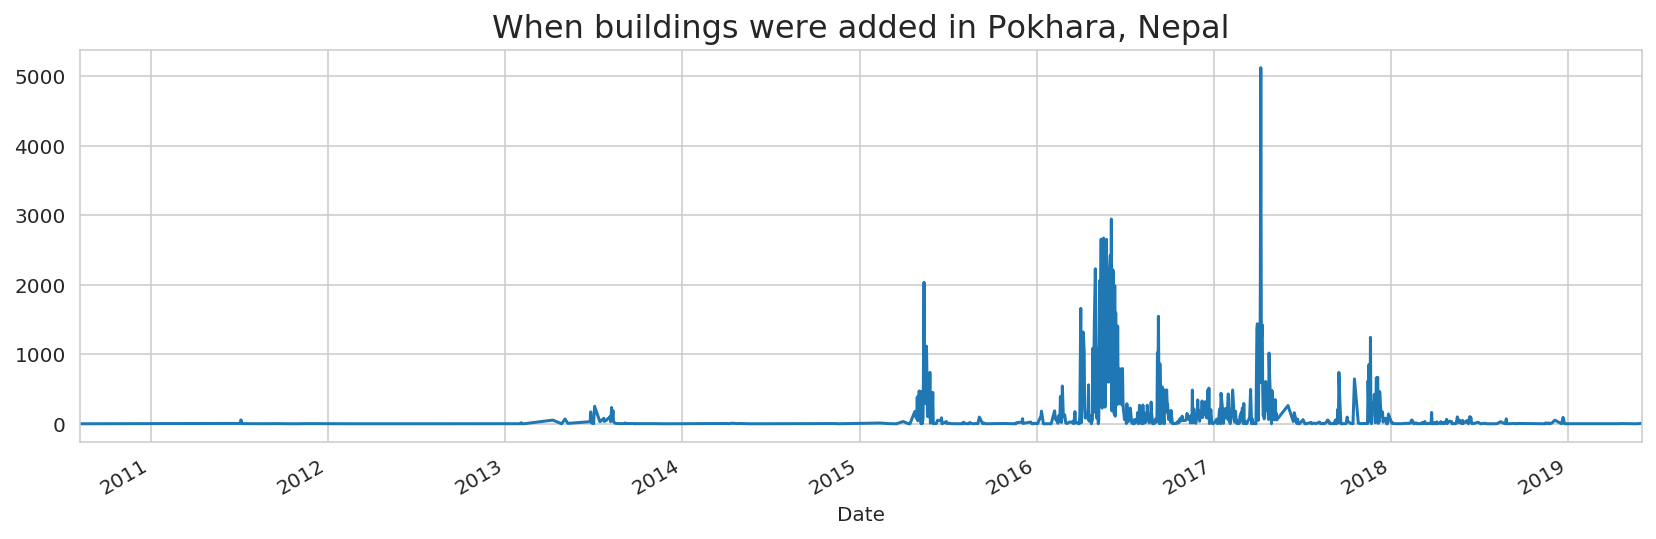

In [227]:
ax = df['objects'].plot(figsize=(14,4))
ax.set_xlabel("Date"); ax.set_ylabel(""); ax.set_title("When buildings were added in Pokhara, Nepal",fontsize=16);

While we see the Earthquake in April 2015 has a major effect on the number of new buildings, we {

The majority of the buildings in Pokhara, Nepal were not added after the earthquake. Instead, a year after the earthquake saw the largest building mapping efforts.

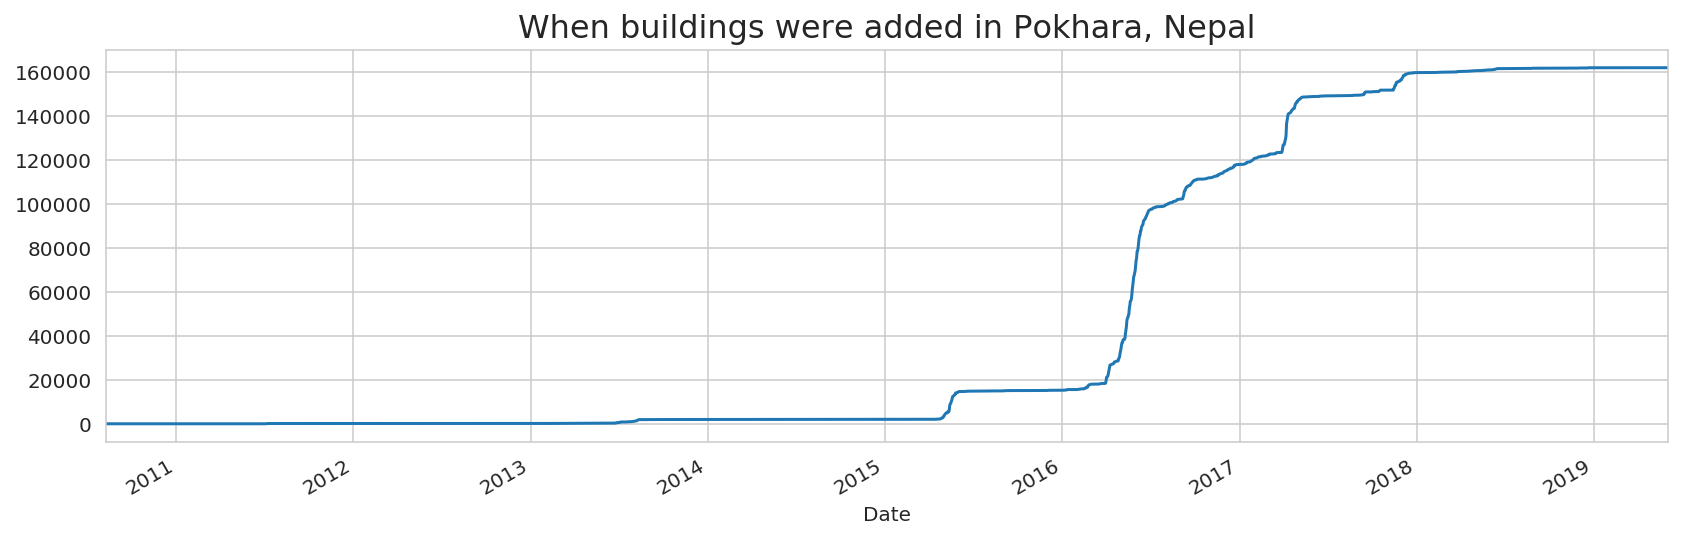

In [228]:
ax = df['objects'].cumsum().plot(figsize=(14,4))
ax.set_xlabel("Date"); ax.set_ylabel(""); ax.set_title("When buildings were added in Pokhara, Nepal",fontsize=16);